- Created by Akash Kharita (PhD student, University of Washington)
-05/26/2024

This notebook involves comparison of performance of the random forest model trained on the commbination of over physical and tsfel features for various sampling rates, window lengths, and frequency bands 

In [163]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os
import sys
sys.path.append('../common_scripts')

from common_processing_functions import apply_cosine_taper
from common_processing_functions import butterworth_filter

import pickle
from zenodo_get import zenodo_get

from multiprocessing import Pool, cpu_count
from scipy.signal import resample
import pickle

In [236]:
def resample_array(arr, original_rate, desired_rate):
    num_samples = len(arr)
    duration = num_samples / original_rate  # Duration of the array in seconds
    new_num_samples = int(duration * desired_rate)
    return resample(arr, new_num_samples)




def process_file(h5_file, indices, buckets, times, win_before, win_after, pick_time, nos):
    data = []
    t = []
    with h5py.File(h5_file, 'r') as f:
        for i in tqdm(range(nos)):
            data.append(f['/data/' + buckets[i]][indices[i], 2, pick_time - win_before:pick_time + win_after])
            t.append(UTCDateTime(times[i]))
    return np.array(data), np.array(t)

def extract_features(data, t, cfg_file, fs):
    df = pd.DataFrame([])
    for i in tqdm(range(len(data))):
        try:
            tsfel_features = tsfel.time_series_features_extractor(cfg_file, data[i], fs=fs, verbose = 0)
            physical_features = seis_feature.FeatureCalculator(data[i], fs=fs).compute_features()
            final_features = pd.concat([tsfel_features, physical_features], axis=1)
            final_features['hod'] = t[i].hour - 8
            final_features['dow'] = t[i].weekday
            final_features['moy'] = t[i].month
            df = pd.concat([df, final_features])
        except:
            pass
  
    return df

def compute_features(win_before=2000, win_after=3000, nos=300, fmin=1, fmax=10, fs=100):
    comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
    comcat_csv_file = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

    buckets = [name.split('$')[0] for name in comcat_csv_file['trace_name'].values]
    indices = [int(name.split('$')[1].split(',')[0]) for name in comcat_csv_file['trace_name'].values]
    source = comcat_csv_file['source_type'].values

    exp_indices = np.where(source == 'explosion')[0]
    eq_indices = np.where(source == 'earthquake')[0]

    data_exp, t_exp = process_file(comcat_file_name, np.array(indices)[exp_indices], np.array(buckets)[exp_indices], 
                                   comcat_csv_file['trace_start_time'].values[exp_indices], win_before, win_after, 5000, nos)
    
    data_eq, t_eq = process_file(comcat_file_name, np.array(indices)[eq_indices], np.array(buckets)[eq_indices], 
                                 comcat_csv_file['trace_start_time'].values[eq_indices], win_before, win_after, 5000, nos)

    exotic_file_name = "/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5"
    exotic_csv_file = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
    
    buckets = [name.split('$')[0] for name in exotic_csv_file['trace_name'].values]
    indices = [int(name.split('$')[1].split(',')[0]) for name in exotic_csv_file['trace_name'].values]
    source = exotic_csv_file['source_type'].values
    
    su_indices = np.where(source == 'surface event')[0]

    data_su, t_su = process_file(exotic_file_name, np.array(indices)[su_indices], np.array(buckets)[su_indices], 
                                 exotic_csv_file['trace_start_time'].values[su_indices], win_before, win_after, 7000, nos)

    noise_file_name = "/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5"
    noise_csv_file = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

    buckets = [name.split('$')[0] for name in noise_csv_file['trace_name'].values]
    indices = [int(name.split('$')[1].split(',')[0]) for name in noise_csv_file['trace_name'].values]

    data_no, t_no = process_file(noise_file_name, np.array(indices), np.array(buckets), 
                                 noise_csv_file['trace_start_time'].values, win_before, win_after, 5000, nos)

    tp = 10
    nc = 4

    def process_data(data):
        tapered = apply_cosine_taper(data, taper_percent=tp)
        filtered = np.array(butterworth_filter(tapered, fmin, fmax, fs, nc, 'bandpass'))
        return filtered / np.max(np.abs(filtered), axis=1)[:, np.newaxis]

    norm_eq = process_data(data_eq)
    norm_exp = process_data(data_exp)
    norm_su = process_data(data_su)
    norm_no = process_data(data_no)

    norm_eq = np.array([resample_array(arr, 100, fs) for arr in norm_eq])
    norm_exp = np.array([resample_array(arr, 100, fs) for arr in norm_exp])
    norm_su = np.array([resample_array(arr, 100, fs) for arr in norm_su])
    norm_no = np.array([resample_array(arr, 100, fs) for arr in norm_no])
    
    print(len(norm_eq[0]))
    
    cfg_file = tsfel.get_features_by_domain()

    with Pool(cpu_count()) as pool:
        df_eq = pool.apply_async(extract_features, (norm_eq, t_eq, cfg_file, fs)).get()
        df_exp = pool.apply_async(extract_features, (norm_exp, t_exp, cfg_file, fs)).get()
        df_su = pool.apply_async(extract_features, (norm_su, t_su, cfg_file, fs)).get()
        df_no = pool.apply_async(extract_features, (norm_no, t_no, cfg_file, fs)).get()

    return df_eq, df_exp, df_su, df_no




def compute_features_single_core(win_before=2000, win_after=3000, nos=10, fmin=1, fmax=10, fs=100):
    comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
    comcat_csv_file = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

    buckets = [name.split('$')[0] for name in comcat_csv_file['trace_name'].values]
    indices = [int(name.split('$')[1].split(',')[0]) for name in comcat_csv_file['trace_name'].values]
    source = comcat_csv_file['source_type'].values

    exp_indices = np.where(source == 'explosion')[0]
    eq_indices = np.where(source == 'earthquake')[0]

    data_exp, t_exp = process_file(comcat_file_name, np.array(indices)[exp_indices], np.array(buckets)[exp_indices], 
                                   comcat_csv_file['trace_start_time'].values[exp_indices], win_before, win_after, 5000, nos)
    
    data_eq, t_eq = process_file(comcat_file_name, np.array(indices)[eq_indices], np.array(buckets)[eq_indices], 
                                 comcat_csv_file['trace_start_time'].values[eq_indices], win_before, win_after, 5000, nos)

    exotic_file_name = "/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5"
    exotic_csv_file = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
    
    buckets = [name.split('$')[0] for name in exotic_csv_file['trace_name'].values]
    indices = [int(name.split('$')[1].split(',')[0]) for name in exotic_csv_file['trace_name'].values]
    source = exotic_csv_file['source_type'].values
    
    su_indices = np.where(source == 'surface event')[0]

    data_su, t_su = process_file(exotic_file_name, np.array(indices)[su_indices], np.array(buckets)[su_indices], 
                                 exotic_csv_file['trace_start_time'].values[su_indices], win_before, win_after, 7000, nos)

    noise_file_name = "/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5"
    noise_csv_file = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

    buckets = [name.split('$')[0] for name in noise_csv_file['trace_name'].values]
    indices = [int(name.split('$')[1].split(',')[0]) for name in noise_csv_file['trace_name'].values]

    data_no, t_no = process_file(noise_file_name, np.array(indices), np.array(buckets), 
                                 noise_csv_file['trace_start_time'].values, win_before, win_after, 5000, nos)

    tp = 10
    nc = 4

    def process_data(data):
        tapered = apply_cosine_taper(data, taper_percent=tp)
        filtered = np.array(butterworth_filter(tapered, fmin, fmax, fs, nc, 'bandpass'))
        return filtered / np.max(np.abs(filtered), axis=1)[:, np.newaxis]

    norm_eq = process_data(data_eq)
    norm_exp = process_data(data_exp)
    norm_su = process_data(data_su)
    norm_no = process_data(data_no)

    norm_eq = np.array([resample_array(arr, 100, fs) for arr in norm_eq])
    norm_exp = np.array([resample_array(arr, 100, fs) for arr in norm_exp])
    norm_su = np.array([resample_array(arr, 100, fs) for arr in norm_su])
    norm_no = np.array([resample_array(arr, 100, fs) for arr in norm_no])
    
    print(len(norm_eq[0]))
    
    cfg_file = tsfel.get_features_by_domain()

    # Sequential feature extraction instead of parallel
    df_eq = extract_features(norm_eq, t_eq, cfg_file, fs)
    df_exp = extract_features(norm_exp, t_exp, cfg_file, fs)
    df_su = extract_features(norm_su, t_su, cfg_file, fs)
    df_no = extract_features(norm_no, t_no, cfg_file, fs)

    return df_eq, df_exp, df_su, df_no


def return_classification_report(all_results):
    cr_all = []
    for i in tqdm(range(len(all_results))):
        a, b, c, d = all_results[0][1][0], all_results[0][1][1], all_results[0][1][2], all_results[0][1][3]

        all_features = pd.concat([a, b, c, d])
        y = ['earthquake']*len(a)+['explosion']*len(b)+['surface']*len(c)+['noise']*len(d)
        all_features['source'] = y
        all_features = all_features.dropna(axis = 1)

        all_features = all_features.replace([np.inf, -np.inf], np.nan)
        all_features = all_features.dropna()
        x = all_features.drop(['source'], axis = 1)
        y  = all_features['source'].values


        # Initialize the LabelEncoder
        label_encoder = LabelEncoder()

        # Fit the LabelEncoder on the text labels and transform them to numeric labels
        y_num = label_encoder.fit_transform(y)

        # Initialize the StandardScaler
        scaler = StandardScaler()

        # Apply standard scaling to the DataFrame
        scaled_features = scaler.fit_transform(x)

        # Create a new DataFrame with scaled features
        x_scaled = pd.DataFrame(scaled_features, columns=x.columns)



        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_num, test_size=0.3)


        # Initialize the Random Forest model
        rf_model = RandomForestClassifier(random_state=42)


        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_test)

        cr_all.append(classification_report(y_test, y_pred, output_dict = True))
        
        
        
    return cr_all

In [237]:
## Extracting for 40 Hz
# Define the path to your pickle file
file_path = '../results/results_40.pkl'

# Open the pickle file in read-binary mode
with open(file_path, 'rb') as file:
    # Load the content of the pickle file
    all_results_40 = pickle.load(file)
    

## Extracting for 50 Hz
# Define the path to your pickle file
file_path = '../results/results_50.pkl'

# Open the pickle file in read-binary mode
with open(file_path, 'rb') as file:
    # Load the content of the pickle file
    all_results_50 = pickle.load(file)


## Extracting for 100 Hz
# Define the path to your pickle file
file_path = '../results/results_100.pkl'

# Open the pickle file in read-binary mode
with open(file_path, 'rb') as file:
    # Load the content of the pickle file
    all_results_100 = pickle.load(file)

In [247]:
big_40 = []
big_50 = []
big_100 = []

n_iter = 10

for i in tqdm(range(n_iter)):
    big_40.append(return_classification_report(all_results_40))
    big_50.append(return_classification_report(all_results_50))
    big_100.append(return_classification_report(all_results_100))

100%|██████████| 20/20 [04:02<00:00, 12.10s/it]

100%|██████████| 20/20 [04:10<00:00, 12.51s/it]

100%|██████████| 20/20 [04:02<00:00, 12.13s/it]

100%|██████████| 20/20 [04:11<00:00, 12.58s/it]

100%|██████████| 20/20 [04:01<00:00, 12.09s/it]

 60%|██████    | 12/20 [02:30<01:40, 12.55s/it]


100%|██████████| 20/20 [04:10<00:00, 12.55s/it]

100%|██████████| 20/20 [04:03<00:00, 12.15s/it]

100%|██████████| 20/20 [04:10<00:00, 12.52s/it]

100%|██████████| 20/20 [04:03<00:00, 12.16s/it]

100%|██████████| 20/20 [04:10<00:00, 12.54s/it]

 20%|██        | 4/20 [00:48<03:13, 12.12s/it]


100%|██████████| 20/20 [04:02<00:00, 12.14s/it]

100%|██████████| 20/20 [04:09<00:00, 12.46s/it]

100%|██████████| 20/20 [04:03<00:00, 12.16s/it]

100%|██████████| 20/20 [04:10<00:00, 12.50s/it]

100%|██████████| 20/20 [04:02<00:00, 12.13s/it]

 90%|█████████ | 18/20 [03:44<00:25, 12.52s/it]


100%|██████████| 20/20 [04:09<00:00, 12.48s/it]

100%|██████████| 20/20 [04:03<00:00, 12.17s/it]

100%|██████████| 20/20 [04:10<00:00, 12.51s/it]

100%|██████████| 20/20 [04:02<00:00, 12.12s/it]

100%|██████████| 20/20 [04:11<00:00, 12.56s/it]

100%|██████████| 10/10 [2:06:07<00:00, 756.79s/it]


20

In [252]:
# Function to extract F1 scores from cr_all
def extract_f1_scores(cr_all):
    f1_scores = []
    for i in range(20):
        f1_score = pd.DataFrame(cr_all[i]).loc['f1-score', 'macro avg']
        f1_scores.append(f1_score)
    return f1_scores

# Extract F1 scores for each sampling rate

big_f1_40 = []
big_f1_50 = []
big_f1_100 = []



for i in range(n_iter):
    big_f1_40.append(extract_f1_scores(big_40[i]))
    big_f1_50.append(extract_f1_scores(big_50[i]))
    big_f1_100.append(extract_f1_scores(big_100[i]))

In [261]:
f1_scores_40 = np.mean(np.array(big_f1_40), axis = 0)
f1_scores_50 = np.mean(np.array(big_f1_50), axis = 0)
f1_scores_100 = np.mean(np.array(big_f1_100), axis = 0)

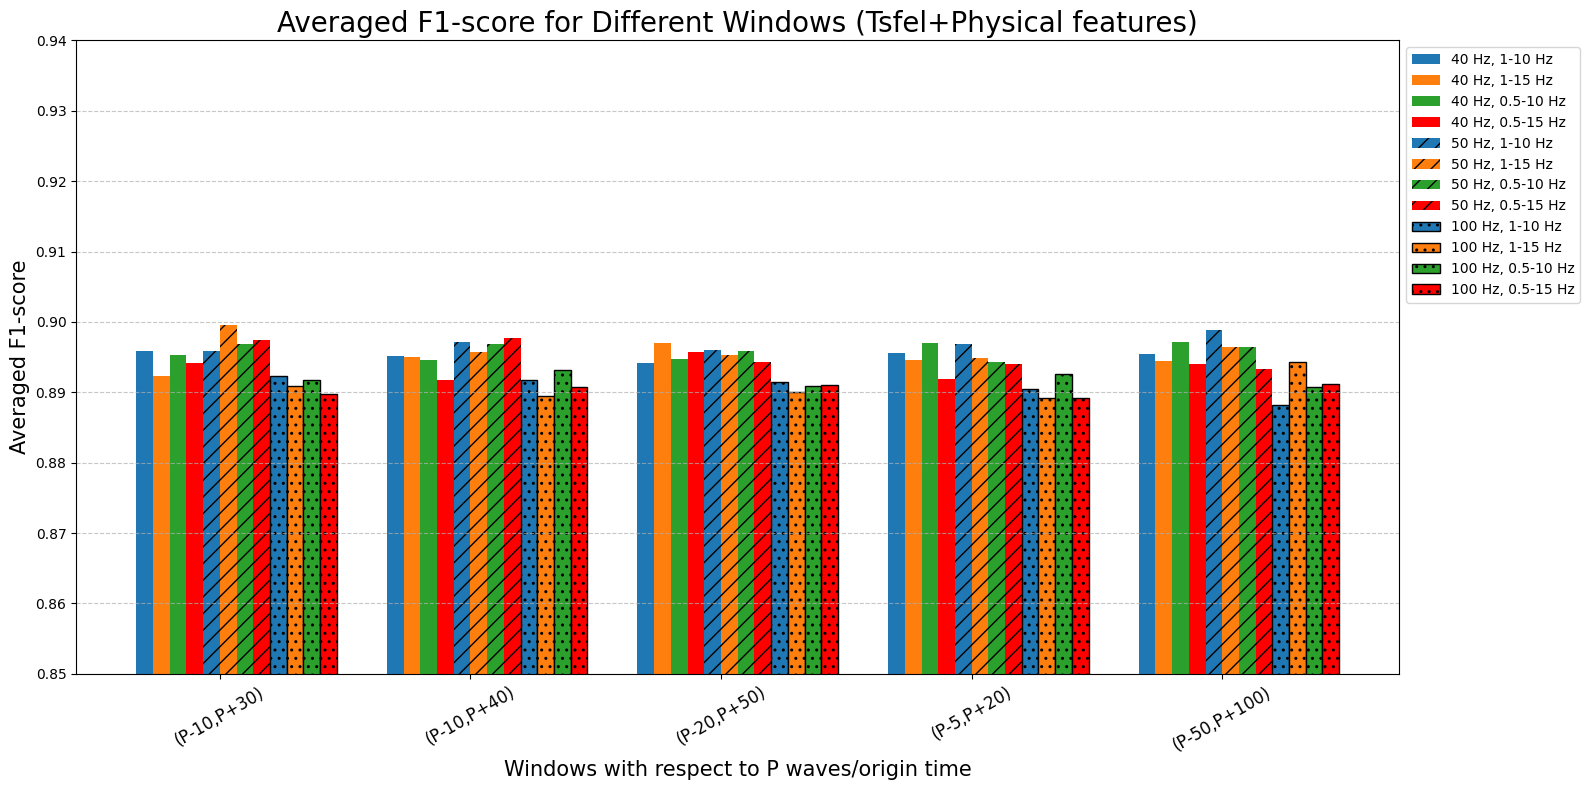

In [262]:
# Split F1 scores into frequency bands
f1_scores_1_10_40, f1_scores_1_15_40, f1_scores_05_10_40, f1_scores_05_15_40 = f1_scores_40[:5], f1_scores_40[5:10], f1_scores_40[10:15], f1_scores_40[15:20]
f1_scores_1_10_50, f1_scores_1_15_50, f1_scores_05_10_50, f1_scores_05_15_50 = f1_scores_50[:5], f1_scores_50[5:10], f1_scores_50[10:15], f1_scores_50[15:20]
f1_scores_1_10_100, f1_scores_1_15_100, f1_scores_05_10_100, f1_scores_05_15_100 = f1_scores_100[:5], f1_scores_100[5:10], f1_scores_100[10:15], f1_scores_100[15:20]

windows = ['(P-10,P+30)', '(P-10,P+40)', '(P-20,P+50)', '(P-5,P+20)', '(P-50,P+100)']
bar_width = 0.20  # Width of each bar
index = np.arange(len(windows)) * 3  # Increase the separation between ticks

# Color blind friendly palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'red']

plt.figure(figsize=(16, 8))

# Plot for 40 Hz
plt.bar(index - 2 * bar_width, f1_scores_1_10_40, bar_width, label='40 Hz, 1-10 Hz', color=colors[0])
plt.bar(index - 1 * bar_width, f1_scores_1_15_40, bar_width, label='40 Hz, 1-15 Hz', color=colors[1])
plt.bar(index + 0 * bar_width, f1_scores_05_10_40, bar_width, label='40 Hz, 0.5-10 Hz', color=colors[2])
plt.bar(index + 1 * bar_width, f1_scores_05_15_40, bar_width, label='40 Hz, 0.5-15 Hz', color=colors[3])

# Plot for 50 Hz
plt.bar(index + 2 * bar_width, f1_scores_1_10_50, bar_width, label='50 Hz, 1-10 Hz', color=colors[0], hatch='//')
plt.bar(index + 3 * bar_width, f1_scores_1_15_50, bar_width, label='50 Hz, 1-15 Hz', color=colors[1], hatch='//')
plt.bar(index + 4 * bar_width, f1_scores_05_10_50, bar_width, label='50 Hz, 0.5-10 Hz', color=colors[2], hatch='//')
plt.bar(index + 5 * bar_width, f1_scores_05_15_50, bar_width, label='50 Hz, 0.5-15 Hz', color=colors[3], hatch='//')

# Plot for 100 Hz
plt.bar(index + 6 * bar_width, f1_scores_1_10_100, bar_width, label='100 Hz, 1-10 Hz', color=colors[0], edgecolor='black', hatch='..')
plt.bar(index + 7 * bar_width, f1_scores_1_15_100, bar_width, label='100 Hz, 1-15 Hz', color=colors[1], edgecolor='black', hatch='..')
plt.bar(index + 8 * bar_width, f1_scores_05_10_100, bar_width, label='100 Hz, 0.5-10 Hz', color=colors[2], edgecolor='black', hatch='..')
plt.bar(index + 9 * bar_width, f1_scores_05_15_100, bar_width, label='100 Hz, 0.5-15 Hz', color=colors[3], edgecolor='black', hatch='..')

# Add labels, title, and legend
plt.xlabel('Windows with respect to P waves/origin time', fontsize=15)
plt.ylabel('Averaged F1-score', fontsize=15)
plt.xticks(index + 2.5 * bar_width, windows, rotation=30, fontsize=12)
plt.ylim(0.85, 0.94)
plt.title('Averaged F1-score for Different Windows (Tsfel+Physical features)', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.grid(True, which='minor', linestyle='--', alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save or display the plot
plt.tight_layout()
plt.savefig('combined_f1_scores_plot.png', dpi=300)
plt.show()


## Computing the feature extraction time

In [240]:
def compute_time(sr = 50, nos = 5):
    def run_compute_features(params):
        results = []
        for param in params:
            # Extract prefix and remove it from the parameter dictionary
            prefix = param.pop("prefix")
            results.append((prefix, compute_features(**param)))
            # Re-add the prefix for any future use of the parameter set
            param["prefix"] = prefix
        return results




    # Parameters for different runs
    param_sets = [
        {"win_before": 1000, "win_after": 3000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "10_30_1_10_50"},
        {"win_before": 1000, "win_after": 4000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "10_40_1_10_50"},
        {"win_before": 2000, "win_after": 5000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "20_50_1_10_50"},
        {"win_before": 500, "win_after": 2000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "05_20_1_10_50"},
        {"win_before": 5000, "win_after": 10000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "50_100_1_10_50"},
        {"win_before": 1000, "win_after": 3000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "10_30_1_15_50"},
        {"win_before": 1000, "win_after": 4000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "10_40_1_15_50"},
        {"win_before": 2000, "win_after": 5000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "20_50_1_15_50"},
        {"win_before": 500, "win_after": 2000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "05_20_1_15_50"},
        {"win_before": 5000, "win_after": 10000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "50_100_1_15_50"},
        {"win_before": 1000, "win_after": 3000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "10_30_05_10_50"},
        {"win_before": 1000, "win_after": 4000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "10_40_05_10_50"},
        {"win_before": 2000, "win_after": 5000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "20_50_05_10_50"},
        {"win_before": 500, "win_after": 2000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "05_20_05_10_50"},
        {"win_before": 5000, "win_after": 10000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "50_100_05_10_50"},
        {"win_before": 1000, "win_after": 3000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "10_30_05_15_50"},
        {"win_before": 1000, "win_after": 4000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "10_40_05_15_50"},
        {"win_before": 2000, "win_after": 5000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "20_50_05_15_50"},
        {"win_before": 500, "win_after": 2000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "05_20_05_15_50"},
        {"win_before": 5000, "win_after": 10000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "50_100_05_15_50"}
    ]

    # Run the computations and measure time
    all_results_50 = []
    all_time_50 = []
    for param_set in param_sets:
        init_time = time.time()
        results = run_compute_features([param_set])
        for prefix, result in results:
            a, b, c, d = result
            all_time_50.append(time.time() - init_time)
            all_results_50.append((prefix, result))
            
    return all_time_50




def compute_time_single_core(sr = 50, nos = 10):
    def run_compute_features(params):
        results = []
        for param in params:
            # Extract prefix and remove it from the parameter dictionary
            prefix = param.pop("prefix")
            results.append((prefix, compute_features_single_core(**param)))
            # Re-add the prefix for any future use of the parameter set
            param["prefix"] = prefix
        return results




    # Parameters for different runs
    param_sets = [
        {"win_before": 1000, "win_after": 3000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "10_30_1_10_50"},
        {"win_before": 1000, "win_after": 4000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "10_40_1_10_50"},
        {"win_before": 2000, "win_after": 5000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "20_50_1_10_50"},
        {"win_before": 500, "win_after": 2000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "05_20_1_10_50"},
        {"win_before": 5000, "win_after": 10000, "nos": nos, "fmin": 1, "fmax": 10, "fs": sr, "prefix": "50_100_1_10_50"},
        {"win_before": 1000, "win_after": 3000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "10_30_1_15_50"},
        {"win_before": 1000, "win_after": 4000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "10_40_1_15_50"},
        {"win_before": 2000, "win_after": 5000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "20_50_1_15_50"},
        {"win_before": 500, "win_after": 2000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "05_20_1_15_50"},
        {"win_before": 5000, "win_after": 10000, "nos": nos, "fmin": 1, "fmax": 15, "fs": sr, "prefix": "50_100_1_15_50"},
        {"win_before": 1000, "win_after": 3000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "10_30_05_10_50"},
        {"win_before": 1000, "win_after": 4000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "10_40_05_10_50"},
        {"win_before": 2000, "win_after": 5000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "20_50_05_10_50"},
        {"win_before": 500, "win_after": 2000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "05_20_05_10_50"},
        {"win_before": 5000, "win_after": 10000, "nos": nos, "fmin": 0.5, "fmax": 10, "fs": sr, "prefix": "50_100_05_10_50"},
        {"win_before": 1000, "win_after": 3000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "10_30_05_15_50"},
        {"win_before": 1000, "win_after": 4000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "10_40_05_15_50"},
        {"win_before": 2000, "win_after": 5000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "20_50_05_15_50"},
        {"win_before": 500, "win_after": 2000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "05_20_05_15_50"},
        {"win_before": 5000, "win_after": 10000, "nos": nos, "fmin": 0.5, "fmax": 15, "fs": sr, "prefix": "50_100_05_15_50"}
    ]

    # Run the computations and measure time
    all_results_50 = []
    all_time_50 = []
    for param_set in param_sets:
        init_time = time.time()
        results = run_compute_features([param_set])
        for prefix, result in results:
            a, b, c, d = result
            all_time_50.append(time.time() - init_time)
            all_results_50.append((prefix, result))
            
    return all_time_50





In [241]:
all_time_40 = compute_time(40)
all_time_50 = compute_time(50)
all_time_100 = compute_time(100)

100%|██████████| 5/5 [00:00<00:00, 244.56it/s]

1600



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2800


  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runti

1000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

6000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1600



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2800



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

6000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1600



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2800



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

6000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1600



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2800



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

6000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

3500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1250



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

7500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

3500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1250



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

7500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

3500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1250



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

7500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

3500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

1250



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

7500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

4000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

5000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

7000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

15000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

4000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

5000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

7000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

15000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

4000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

5000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

7000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

15000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

4000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

5000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

7000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

2500



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

15000



  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: Runt

In [242]:
all_time_40_sc = compute_time_single_core(40, nos = 5)
all_time_50_sc = compute_time_single_core(50, nos = 5)
all_time_100_sc = compute_time_single_core(100, nos = 5)

  0%|          | 0/5 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:101: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
 40%|████      | 2/5 [00:00<00:00, 19.35it/s]

1600


 60%|██████    | 3/5 [00:00<00:00, 23.62it/s]

2000


 60%|██████    | 3/5 [00:00<00:00, 22.28it/s]

2800


  0%|          | 0/5 [00:00<?, ?it/s]

1000


 40%|████      | 2/5 [00:00<00:00, 16.58it/s]

6000


100%|██████████| 5/5 [00:00<00:00, 25.03it/s]

1600



 60%|██████    | 3/5 [00:00<00:00, 24.01it/s]

2000


 60%|██████    | 3/5 [00:00<00:00, 22.69it/s]

2800


  0%|          | 0/5 [00:00<?, ?it/s]

1000


 40%|████      | 2/5 [00:00<00:00, 16.53it/s]

6000


  0%|          | 0/5 [00:00<?, ?it/s]

1600


 60%|██████    | 3/5 [00:00<00:00, 24.34it/s]

2000


 60%|██████    | 3/5 [00:00<00:00, 22.74it/s]

2800


  0%|          | 0/5 [00:00<?, ?it/s]

1000


 40%|████      | 2/5 [00:00<00:00, 16.69it/s]

6000


  0%|          | 0/5 [00:00<?, ?it/s]

1600


 60%|██████    | 3/5 [00:00<00:00, 24.11it/s]

2000


 60%|██████    | 3/5 [00:00<00:00, 22.81it/s]

2800


  0%|          | 0/5 [00:00<?, ?it/s]

1000


 40%|████      | 2/5 [00:00<00:00, 17.17it/s]

6000


 60%|██████    | 3/5 [00:00<00:00, 23.70it/s]

2000


 60%|██████    | 3/5 [00:00<00:00, 22.82it/s]

2500


 60%|██████    | 3/5 [00:00<00:00, 21.28it/s]

3500


  0%|          | 0/5 [00:00<?, ?it/s]

1250


 40%|████      | 2/5 [00:00<00:00, 14.52it/s]

7500


 60%|██████    | 3/5 [00:00<00:00, 23.75it/s]

2000


 60%|██████    | 3/5 [00:00<00:00, 22.41it/s]

2500


 60%|██████    | 3/5 [00:00<00:00, 21.16it/s]

3500


  0%|          | 0/5 [00:00<?, ?it/s]

1250


 40%|████      | 2/5 [00:00<00:00, 14.28it/s]

7500


 60%|██████    | 3/5 [00:00<00:00, 23.72it/s]

2000


 60%|██████    | 3/5 [00:00<00:00, 22.79it/s]

2500


 60%|██████    | 3/5 [00:00<00:00, 21.24it/s]

3500


  0%|          | 0/5 [00:00<?, ?it/s]

1250


 40%|████      | 2/5 [00:00<00:00, 14.11it/s]

7500


 60%|██████    | 3/5 [00:00<00:00, 23.61it/s]

2000


 60%|██████    | 3/5 [00:00<00:00, 22.73it/s]

2500


 60%|██████    | 3/5 [00:00<00:00, 21.13it/s]

3500


  0%|          | 0/5 [00:00<?, ?it/s]

1250


 40%|████      | 2/5 [00:00<00:00, 14.19it/s]

7500


 60%|██████    | 3/5 [00:00<00:00, 20.62it/s]

4000


 40%|████      | 2/5 [00:00<00:00, 18.12it/s]

5000


 40%|████      | 2/5 [00:00<00:00, 15.18it/s]

7000


 60%|██████    | 3/5 [00:00<00:00, 22.86it/s]

2500


  0%|          | 0/5 [00:00<?, ?it/s]

15000


 60%|██████    | 3/5 [00:00<00:00, 20.24it/s]

4000


 40%|████      | 2/5 [00:00<00:00, 18.09it/s]

5000


 40%|████      | 2/5 [00:00<00:00, 15.05it/s]

7000


 60%|██████    | 3/5 [00:00<00:00, 21.96it/s]

2500


  0%|          | 0/5 [00:00<?, ?it/s]

15000


 40%|████      | 2/5 [00:00<00:00, 19.75it/s]

4000


 40%|████      | 2/5 [00:00<00:00, 17.91it/s]

5000


 40%|████      | 2/5 [00:00<00:00, 14.76it/s]

7000


 60%|██████    | 3/5 [00:00<00:00, 21.06it/s]

2500


  0%|          | 0/5 [00:00<?, ?it/s]

15000


 60%|██████    | 3/5 [00:00<00:00, 21.45it/s]

4000


 40%|████      | 2/5 [00:00<00:00, 17.94it/s]

5000


 40%|████      | 2/5 [00:00<00:00, 14.92it/s]

7000


 60%|██████    | 3/5 [00:00<00:00, 22.71it/s]

2500


  0%|          | 0/5 [00:00<?, ?it/s]

15000


100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


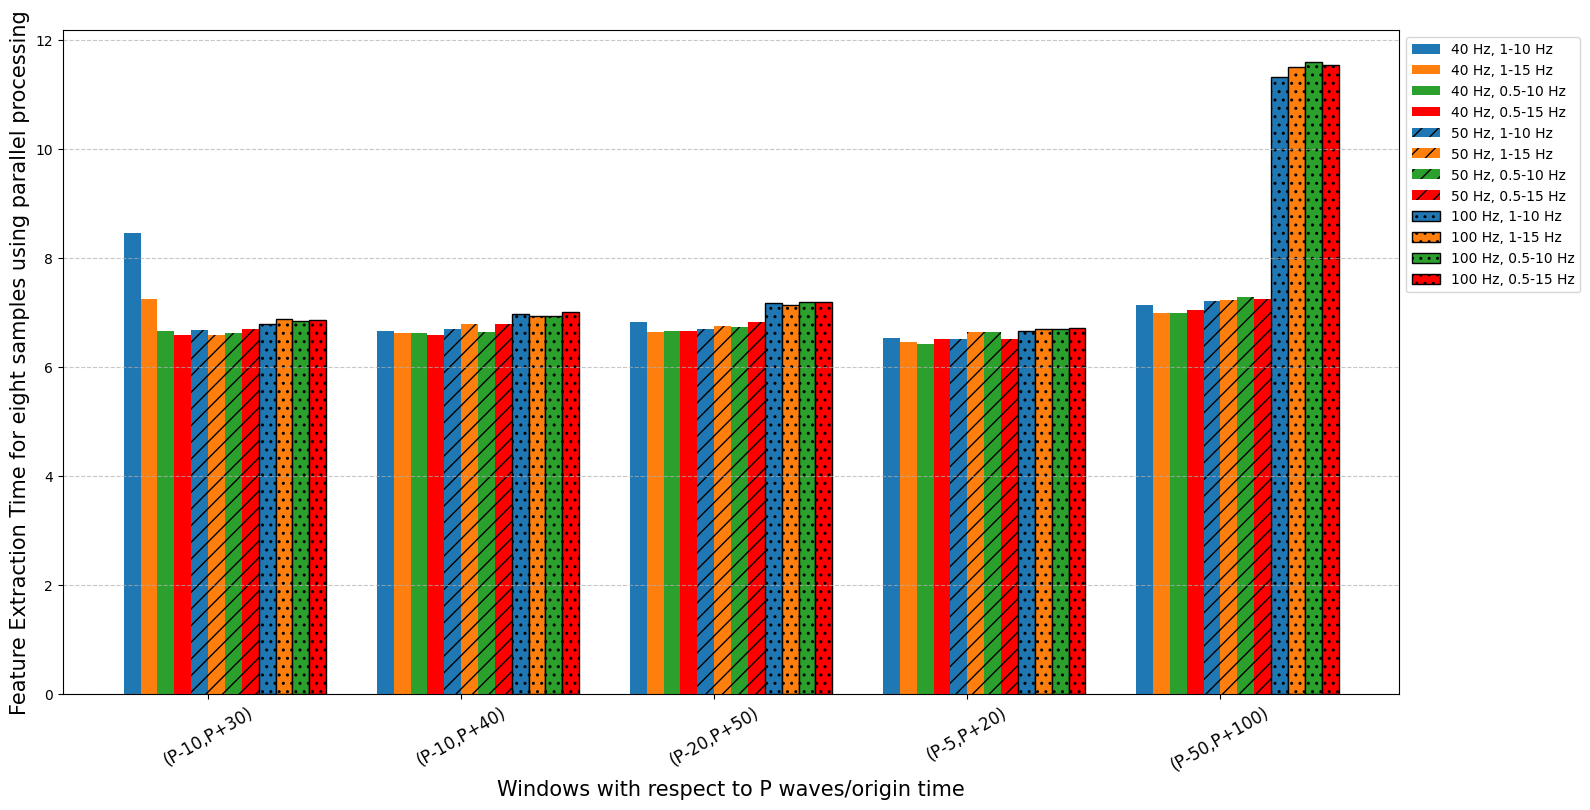

In [243]:
# Function to extract F1 scores from cr_all
def extract_f1_scores(cr_all):
    f1_scores = []
    for i in range(20):
        f1_score = pd.DataFrame(cr_all[i]).loc['f1-score', 'macro avg']
        f1_scores.append(f1_score)
    return f1_scores

# Extract F1 scores for each sampling rate
f1_scores_40 = extract_f1_scores(cr_all_40)
f1_scores_50 = extract_f1_scores(cr_all_50)
f1_scores_100 = extract_f1_scores(cr_all_100)

# Split F1 scores into frequency bands
f1_scores_1_10_40, f1_scores_1_15_40, f1_scores_05_10_40, f1_scores_05_15_40 = all_time_40[:5], all_time_40[5:10], all_time_40[10:15], all_time_40[15:20]
f1_scores_1_10_50, f1_scores_1_15_50, f1_scores_05_10_50, f1_scores_05_15_50 = all_time_50[:5], all_time_50[5:10], all_time_50[10:15], all_time_50[15:20]
f1_scores_1_10_100, f1_scores_1_15_100, f1_scores_05_10_100, f1_scores_05_15_100 = all_time_100[:5], all_time_100[5:10], all_time_100[10:15], all_time_100[15:20]

windows = ['(P-10,P+30)', '(P-10,P+40)', '(P-20,P+50)', '(P-5,P+20)', '(P-50,P+100)']
bar_width = 0.20  # Width of each bar
index = np.arange(len(windows)) * 3  # Increase the separation between ticks

# Color blind friendly palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'red']

plt.figure(figsize=(16, 8))

# Plot for 40 Hz
plt.bar(index - 2 * bar_width, f1_scores_1_10_40, bar_width, label='40 Hz, 1-10 Hz', color=colors[0])
plt.bar(index - 1 * bar_width, f1_scores_1_15_40, bar_width, label='40 Hz, 1-15 Hz', color=colors[1])
plt.bar(index + 0 * bar_width, f1_scores_05_10_40, bar_width, label='40 Hz, 0.5-10 Hz', color=colors[2])
plt.bar(index + 1 * bar_width, f1_scores_05_15_40, bar_width, label='40 Hz, 0.5-15 Hz', color=colors[3])

# Plot for 50 Hz
plt.bar(index + 2 * bar_width, f1_scores_1_10_50, bar_width, label='50 Hz, 1-10 Hz', color=colors[0], hatch='//')
plt.bar(index + 3 * bar_width, f1_scores_1_15_50, bar_width, label='50 Hz, 1-15 Hz', color=colors[1], hatch='//')
plt.bar(index + 4 * bar_width, f1_scores_05_10_50, bar_width, label='50 Hz, 0.5-10 Hz', color=colors[2], hatch='//')
plt.bar(index + 5 * bar_width, f1_scores_05_15_50, bar_width, label='50 Hz, 0.5-15 Hz', color=colors[3], hatch='//')

# Plot for 100 Hz
plt.bar(index + 6 * bar_width, f1_scores_1_10_100, bar_width, label='100 Hz, 1-10 Hz', color=colors[0], edgecolor='black', hatch='..')
plt.bar(index + 7 * bar_width, f1_scores_1_15_100, bar_width, label='100 Hz, 1-15 Hz', color=colors[1], edgecolor='black', hatch='..')
plt.bar(index + 8 * bar_width, f1_scores_05_10_100, bar_width, label='100 Hz, 0.5-10 Hz', color=colors[2], edgecolor='black', hatch='..')
plt.bar(index + 9 * bar_width, f1_scores_05_15_100, bar_width, label='100 Hz, 0.5-15 Hz', color=colors[3], edgecolor='black', hatch='..')

# Add labels, title, and legend
plt.xlabel('Windows with respect to P waves/origin time', fontsize=15)
plt.ylabel('Feature Extraction Time for eight samples using parallel processing', fontsize=15)
plt.xticks(index + 2.5 * bar_width, windows, rotation=30, fontsize=12)
#plt.ylim(0.85, 0.94)
#plt.title('Averaged F1-score for Different Windows (Tsfel+Physical features)', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.grid(True, which='minor', linestyle='--', alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save or display the plot
plt.tight_layout()
plt.savefig('combined_f1_scores_plot.png', dpi=300)
plt.show()


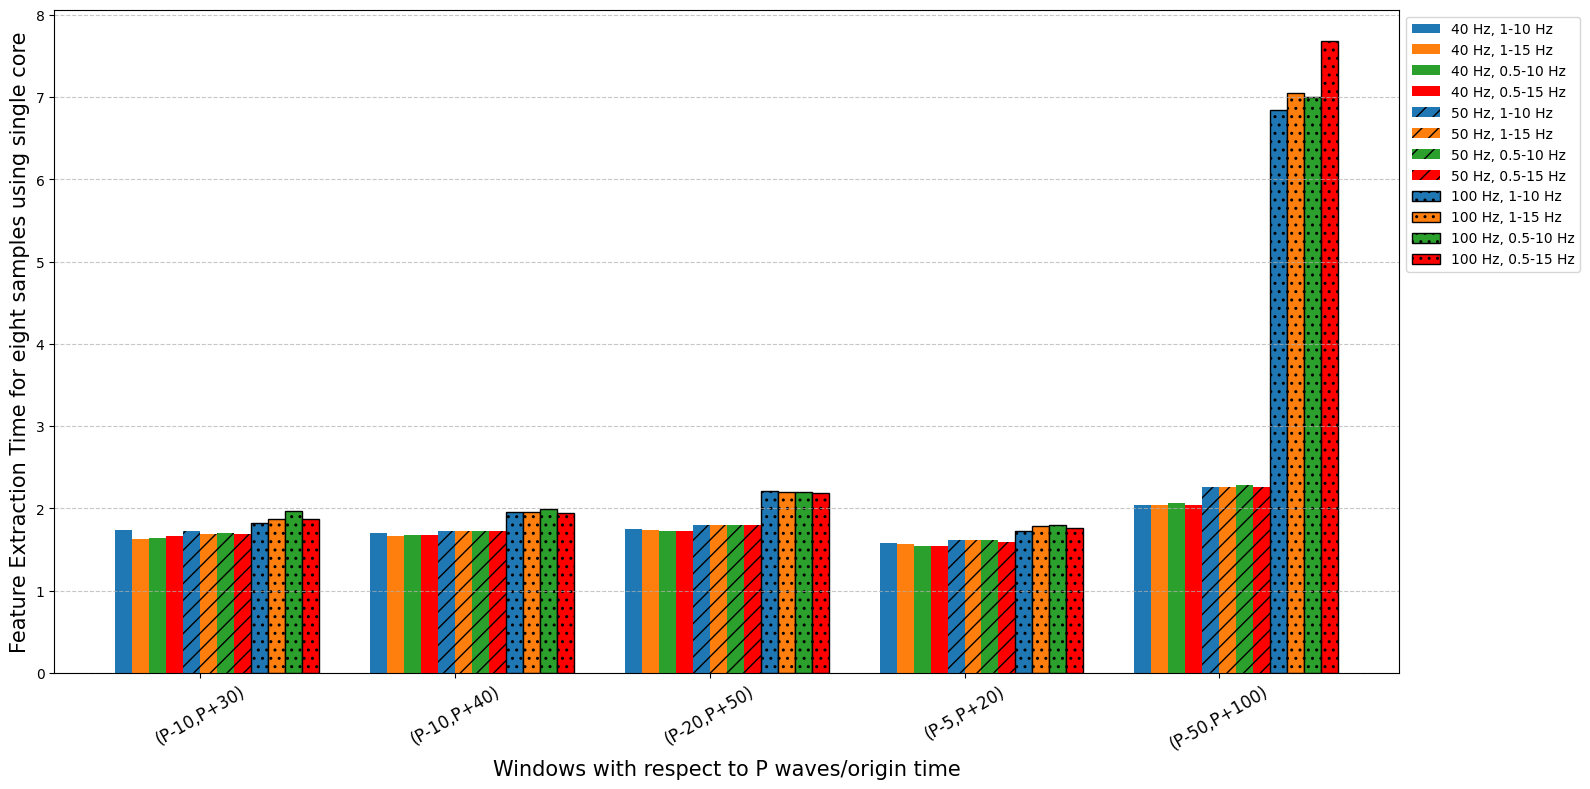

In [244]:
# Function to extract F1 scores from cr_all
def extract_f1_scores(cr_all):
    f1_scores = []
    for i in range(20):
        f1_score = pd.DataFrame(cr_all[i]).loc['f1-score', 'macro avg']
        f1_scores.append(f1_score)
    return f1_scores


# Split F1 scores into frequency bands
f1_scores_1_10_40, f1_scores_1_15_40, f1_scores_05_10_40, f1_scores_05_15_40 = all_time_40_sc[:5], all_time_40_sc[5:10], all_time_40_sc[10:15], all_time_40_sc[15:20]
f1_scores_1_10_50, f1_scores_1_15_50, f1_scores_05_10_50, f1_scores_05_15_50 = all_time_50_sc[:5], all_time_50_sc[5:10], all_time_50_sc[10:15], all_time_50_sc[15:20]
f1_scores_1_10_100, f1_scores_1_15_100, f1_scores_05_10_100, f1_scores_05_15_100 = all_time_100_sc[:5], all_time_100_sc[5:10], all_time_100_sc[10:15], all_time_100_sc[15:20]

windows = ['(P-10,P+30)', '(P-10,P+40)', '(P-20,P+50)', '(P-5,P+20)', '(P-50,P+100)']
bar_width = 0.20  # Width of each bar
index = np.arange(len(windows)) * 3  # Increase the separation between ticks

# Color blind friendly palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'red']

plt.figure(figsize=(16, 8))

# Plot for 40 Hz
plt.bar(index - 2 * bar_width, f1_scores_1_10_40, bar_width, label='40 Hz, 1-10 Hz', color=colors[0])
plt.bar(index - 1 * bar_width, f1_scores_1_15_40, bar_width, label='40 Hz, 1-15 Hz', color=colors[1])
plt.bar(index + 0 * bar_width, f1_scores_05_10_40, bar_width, label='40 Hz, 0.5-10 Hz', color=colors[2])
plt.bar(index + 1 * bar_width, f1_scores_05_15_40, bar_width, label='40 Hz, 0.5-15 Hz', color=colors[3])

# Plot for 50 Hz
plt.bar(index + 2 * bar_width, f1_scores_1_10_50, bar_width, label='50 Hz, 1-10 Hz', color=colors[0], hatch='//')
plt.bar(index + 3 * bar_width, f1_scores_1_15_50, bar_width, label='50 Hz, 1-15 Hz', color=colors[1], hatch='//')
plt.bar(index + 4 * bar_width, f1_scores_05_10_50, bar_width, label='50 Hz, 0.5-10 Hz', color=colors[2], hatch='//')
plt.bar(index + 5 * bar_width, f1_scores_05_15_50, bar_width, label='50 Hz, 0.5-15 Hz', color=colors[3], hatch='//')

# Plot for 100 Hz
plt.bar(index + 6 * bar_width, f1_scores_1_10_100, bar_width, label='100 Hz, 1-10 Hz', color=colors[0], edgecolor='black', hatch='..')
plt.bar(index + 7 * bar_width, f1_scores_1_15_100, bar_width, label='100 Hz, 1-15 Hz', color=colors[1], edgecolor='black', hatch='..')
plt.bar(index + 8 * bar_width, f1_scores_05_10_100, bar_width, label='100 Hz, 0.5-10 Hz', color=colors[2], edgecolor='black', hatch='..')
plt.bar(index + 9 * bar_width, f1_scores_05_15_100, bar_width, label='100 Hz, 0.5-15 Hz', color=colors[3], edgecolor='black', hatch='..')

# Add labels, title, and legend
plt.xlabel('Windows with respect to P waves/origin time', fontsize=15)
plt.ylabel('Feature Extraction Time for eight samples using single core', fontsize=15)
plt.xticks(index + 2.5 * bar_width, windows, rotation=30, fontsize=12)
#plt.ylim(0.85, 0.94)
#plt.title('Averaged F1-score for Different Windows (Tsfel+Physical features)', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.grid(True, which='minor', linestyle='--', alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save or display the plot
plt.tight_layout()
plt.savefig('combined_f1_scores_plot.png', dpi=300)
plt.show()
